In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the random seed for reproducibility
np.random.seed(42)


# Exercise 1: 

Parameter estimation and uncertainties (Assuming Gaussian uncertainties)

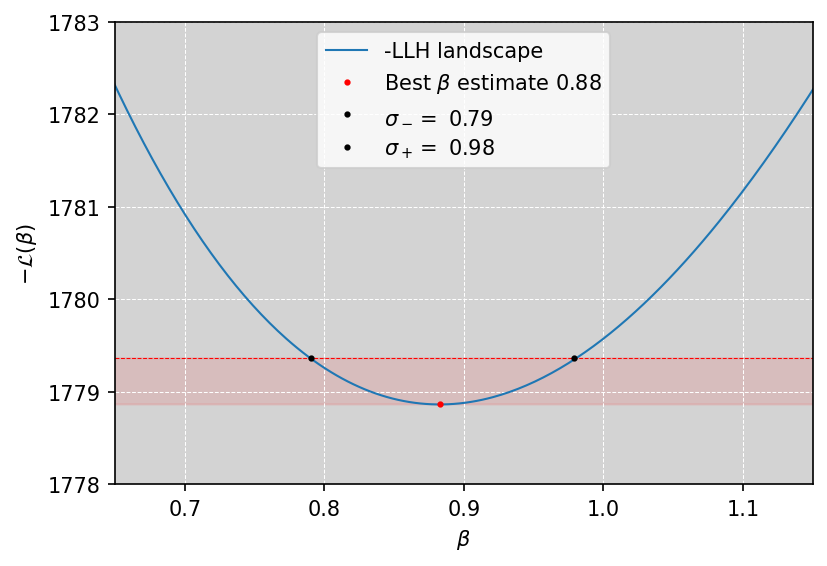

In [2]:
data = np.loadtxt('ParameterEstimation_Ex1.txt')

def pdf(x, alpha, beta):
    return 1 / (2/3 * beta * (0.95)**3 + 2*0.95) * (1 + alpha * x + beta * x**2 )

def llh(params, data):
    return -np.sum(np.log(pdf(data, *params)))

beta = np.linspace(0, 2, 1000)
alpha = 0.65
llh_values = [llh([alpha, b], data) for b in beta]
min_llh = np.min(llh_values)
best_est = beta[np.argmin(llh_values)]
llh_bound = min_llh + 0.5
best_est_unc = beta[llh_values < llh_bound]
best_est_min = np.min(best_est_unc)
best_est_max = np.max(best_est_unc)



fig, ax = plt.subplots(1,1, dpi=150, figsize=(6,4))
ax.plot(beta, llh_values, ls='-', lw=1, label='-LLH landscape')
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$-\mathcal{L}(\beta)$')
ax.set_facecolor('lightgrey')
ax.grid(color='white', linestyle='--', linewidth=0.5)
ax.set(xlim=(0.65, 1.15), ylim=(1778, 1783))
ax.hlines(llh_bound, 0.65, 1.15, color='red', linestyle='--', linewidth=0.5,)
ax.plot(best_est, min_llh, 'ro', markersize=2, label=r'Best $\beta$ estimate {:.2f}'.format(best_est))
ax.plot(best_est_min, llh_bound, marker='.', ls='', color='k', markersize=4, label=r'$\sigma_- = $ {:.2f}'.format(best_est_min))
ax.plot(best_est_max, llh_bound, marker='.', ls='', color='k', markersize=4, label=r'$\sigma_+ = $ {:.2f}'.format(best_est_max))
ax.fill_between(beta, min_llh, llh_bound, color='red', alpha=0.1)

ax.legend()



str_1 = r'$\beta$ = {:.2f}'.format(best_est)
str_2 = fr'$\sigma_- =$ {best_est_min:.2f}, $\sigma_+ = $ {best_est_max:.2f}'

str_join = str_1 + '\n' + str_2

#ax.annotate(str_join, xy=(best_est, min_llh), xytext=(0.3, 1989), arrowprops=dict(facecolor='black', arrowstyle='->'))



# Exercise 2:

Parametric bootstrapping

In [3]:
from scipy.optimize import minimize

x0 = [0.5, 0.5]
res = minimize(llh, x0=x0, args=(data))
alpha_est, beta_est = res.x
print(alpha_est, beta_est)

0.6433926692648463 0.8754734582355248


In [26]:
def acc_rej(N_points, params, xrange=[-0.95, 0.95], yrange=[0,2]):
    n=0
    data = []
    while n < N_points:
        x = np.random.uniform(*xrange)
        y = np.random.uniform(*yrange)
        if y < pdf(x, *params):
            data.append(x)
            n+=1
    return np.array(data)

def para_boot(N_trials, ideal_params, x0=[1,1]):

    boot_params = []
    for i in range(N_trials):
        boot_data = acc_rej(len(data), ideal_params)
        res = minimize(llh, x0=x0, args=(boot_data), method='L-BFGS-B')
        boot_params.append(res.x)
    return np.array(boot_params)

N_trials = 500
boot_params = para_boot(N_trials, [alpha_est, beta_est])

conf_int_95 = np.percentile(boot_params, [2.5, 97.5], axis=0)
print(conf_int_95)



[[0.54776069 0.67525267]
 [0.737171   1.09842362]]


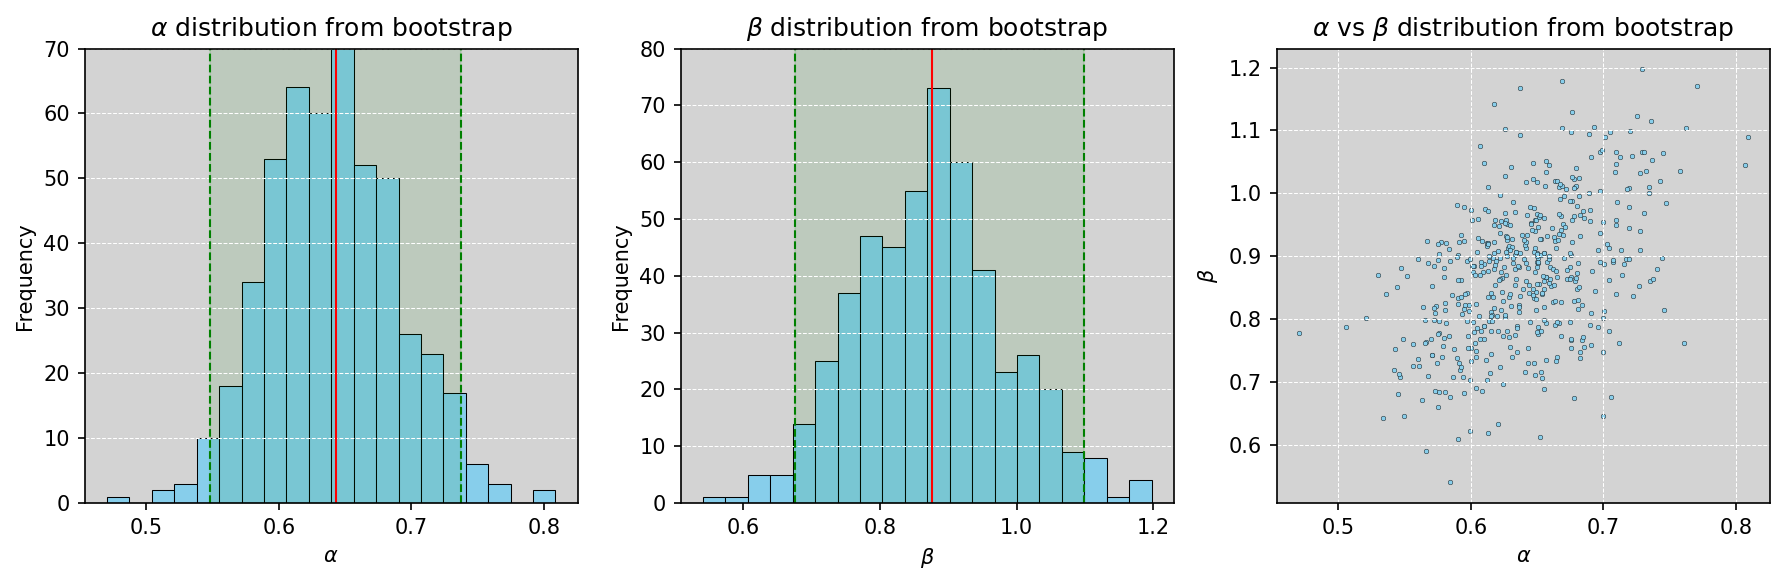

In [31]:

fig, ax = plt.subplots(1,3, dpi=150, figsize=(12,4))
ax[0].grid(color='white', linestyle='--', linewidth=0.5, axis='y')
ax[0].set(ylim=(0,70))
ax[0].hist(boot_params[:,0], bins=20, color='skyblue', edgecolor='black', lw=0.5)
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel('Frequency')
ax[0].set_facecolor('lightgrey')
ax[0].set_title(r'$\alpha$ distribution from bootstrap')
ax[0].vlines(alpha_est, 0, 100, color='red', linestyle='-', linewidth=1, label='True $\alpha$ value')
# plot the 95% confidence interval
ax[0].vlines(conf_int_95[0,0], 0, 100, color='green', linestyle='--', linewidth=1, label='95% CI')
ax[0].vlines(conf_int_95[1,0], 0, 100, color='green', linestyle='--', linewidth=1)
ax[0].fill_betweenx([0,70], conf_int_95[0,0], conf_int_95[1,0], color='green', alpha=0.1)

ax[1].grid(color='white', linestyle='--', linewidth=0.5, axis='y')
ax[1].set(ylim=(0,80))
ax[1].hist(boot_params[:,1], bins=20, color='skyblue', edgecolor='black', lw=0.5)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel('Frequency')
ax[1].set_facecolor('lightgrey')
ax[1].set_title(r'$\beta$ distribution from bootstrap')
ax[1].vlines(beta_est, 0, 100, color='red', linestyle='-', linewidth=1, label='True $\beta$ value')
# plot the 95% confidence interval
ax[1].vlines(conf_int_95[0,1], 0, 100, color='green', linestyle='--', linewidth=1, label='95% CI')
ax[1].vlines(conf_int_95[1,1], 0, 100, color='green', linestyle='--', linewidth=1)
ax[1].fill_betweenx([0,80], conf_int_95[0,1], conf_int_95[1,1], color='green', alpha=0.1)


ax[2].grid(color='white', linestyle='--', linewidth=0.5, axis='both')
ax[2].scatter(boot_params[:,0], boot_params[:,1], s=5, color='skyblue', edgecolor='black', lw=0.2)
ax[2].set_xlabel(r'$\alpha$')
ax[2].set_ylabel(r'$\beta$')
ax[2].set_facecolor('lightgrey')
ax[2].set_title(r'$\alpha$ vs $\beta$ distribution from bootstrap')


fig.tight_layout()
